<img src="./img/HWNI_logo.svg"/>

# Tutorial - Two-Way ANOVA by Hand

In [4]:
# makes our plots show up inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

In the previous section,
we worked out the One-Way ANalysis Of VAriance test
for determining whether means differed across
varying levels of a single factor.

In this tutorial,
we extend the ANOVA test to simultaneous
variation of two or more factors.

## Two-Way ANOVA

$$\begin{align}
    &\text{Observation}\ k\ \text{in Groups}\ i\ \&\ j\ 
    &= \ &\text{Grand Mean}\ 
    &+\ &\text{Group Effect}_i\
    &+\ &\text{Group Effect}_j\
    &+\ &\text{Interaction}_{ij}
    &+ \ &\text{Unknown Effects}_{ijk} \\
    &Y_{ijk} 
    &= \ &\mu_\text{grand} \ 
    &+\ &A_i\
    &+\ &B_j\
    &+\ &AB_{ij}
    &+ \ &\epsilon_{ijk}
\end{align}$$

## Multi-Way ANOVA

$$\begin{align}
    &\text{Observation}
    &= \ &\text{Grand Mean}\ 
    &+\ &\sum{\text{Group Effects}}\
    &+\ &\sum{\text{Interactions}}\
    &+\ &\text{Observation-Specific Unknown Effects}
\end{align}$$

## About the Lab

## About the Dataset

The data for this lab is simulated.

After learning of [Nemeroff, Heim, et al.](http://www.pnas.org/content/100/24/14293.full)'s finding that psychotherapy is more effective at treating depression in individuals with childhood trauma, you become interested in whether the same might be true for treating anxiety.

You run a clinical experiment in which individuals with and without childhood trauma are treated with a placebo, the standard of care for psychotherapy (CBT, or 
["Cognitive Behavioral Therapy"](https://en.wikipedia.org/wiki/Cognitive_behavioral_therapy)),
or the standard of care for pharmacotherapy
(an [anxiolytic GABA agonist](https://en.wikipedia.org/wiki/Anxiolytic)).
As an aside: in actual clinical studies, treatment with a placebo is considered unethical if there's already a standard of care, and a proper clinical trial compares alternative treatments to standard treatments.

The results of your experiment are summarized in the table `anxiety_dataset.csv`.

## Loading the Data

In [31]:
df = pd.read_csv('./data/anxiety_dataset.csv',index_col=0)

data = df.copy()

In [32]:
data.sample(10)

,treatment,trauma,anxiety_reduction
subjectID,,,
13,drug,False,9.0
14,drug,False,6.0
10,placebo,True,2.7
17,placebo,False,2.5
5,cbt,True,7.6
13,placebo,False,3.2
19,cbt,False,3.8
19,placebo,False,1.6
20,drug,False,6.9


For the independent variables `treatment` and `trauma`, use the pandas `Series` method `unique` to determine the levels and store these in variables called `treatments` and `traumas`.

In [33]:
treatments = data.treatment.unique()
traumas = data.trauma.unique()

## Visualizing the Data

Visualize the data. Aim for a visualization that makes it possible to see any main effects along with the interaction effect you're interested in. Examples include: histograms, factorial plots (make sure to include error bars), and strip/swarm/violin plots.

#### Q1 Discuss the connections between visual aspects of your graph and 1) the assumptions of ANOVA and 2) the outcomes you expect.

<font color="1874CD"> 

** The answer below is for the histogram. Information about interpreting the factorial plot can be found in the Miller & Haden readings. **

** The assumption of sphericity (equal variances) can be approximately checked by looking at the width of the distributions. The assumption appears to hold in this case. **

** The main effect of trauma can be assessed by looking at the differences in means within each plot. There may be a small main effect of trauma, but it is difficult to tell. **

** The main effect of treatment can be assessed by looking at the differences of means across the plots. The means of both of the non-placebo treatment groups appear to be higher than that of the placebo group, so we expect a main effect of treatment.**

** The interaction effect of trauma and treatment appears as a difference in the location of the trauma group means depending on treatment. We see here that pharmacotherapy appears more effective on individuals with no trauma, while psychotherapy appears to be more effective on individuals with trauma. We expect, therefore, an interaction effect of trauma and treatment. **

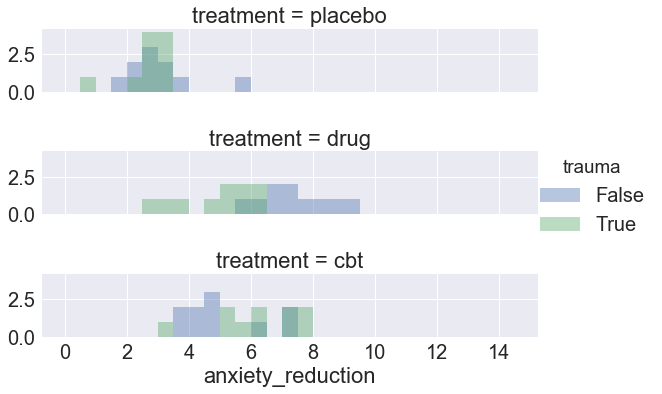

In [34]:
hist_kws = {'histtype':'stepfilled',
               'linewidth':4}

facets = sns.FacetGrid(data=data,
                       row="treatment",
                       hue="trauma",
                        size=2,aspect=4)

facets.map(sns.distplot,"anxiety_reduction",
           kde=False,
           bins=np.arange(0,15,0.5),
           hist_kws=hist_kws).add_legend();

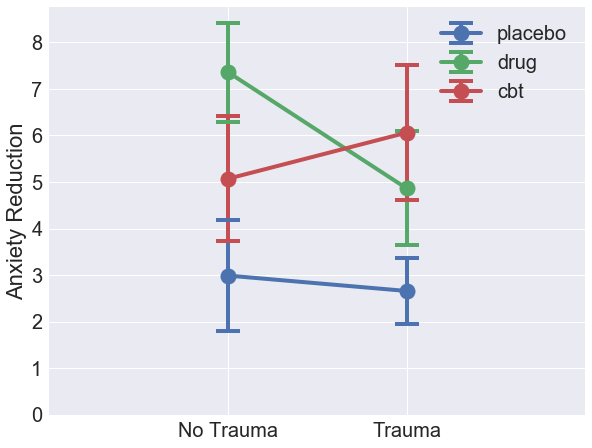

In [35]:
interaction_means = data.groupby(["treatment","trauma"]).mean()

interaction_SDs = data.groupby(["treatment","trauma"]).std()

for treatment in treatments:
    means = interaction_means.loc[treatment].anxiety_reduction
    errs = np.asarray(interaction_SDs.loc[treatment].anxiety_reduction)
    plt.errorbar(x=[0,1],y=means,yerr=errs,label=treatment,
             linewidth=4,alpha=1,capthick=4,capsize=12,
            marker='o',markersize=16)
    
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(["No Trauma","Trauma"])
ax.set_xlim([-1,2])
ax.set_ylabel("Anxiety Reduction")
ylims = ax.get_ylim()
ax.set_ylim([0,ylims[1]])
    
plt.legend();

### Easy Way

Because ANOVA is,
from one perspective,
a test of the goodness-of-fit of a linear model,
many implementations of ANOVA
work by first fitting a linear model
and then testing the fit.

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

We specify models by describing them with strings that look like:

```
    "outcome ~ factor"
```

for one-way ANOVAs,

```
    "outcome ~ factor1*factor2*...factorN"
```

for N-way ANOVAs where we want to compute all main effects and interactions,
and

```
    "outcome ~ factor1:randomFactor1:randomFactor2:...randomFactorN"
```

for ANOVAs with N factors where we're only interested in interactions (e.g., a subject factor).

In [37]:
ols_lm = smf.ols('anxiety_reduction ~ treatment*trauma',data=df)

fit = ols_lm.fit()

table = sm.stats.anova_lm(fit,typ=2)

table

,sum_sq,df,F,PR(>F)
treatment,124.100083,2.0,44.040525,4.530595e-12
trauma,5.612042,1.0,3.983193,5.101057e-02
treatment:trauma,30.958083,2.0,10.986377,9.928169e-05
Residual,76.082250,54.0,NaN,NaN


Hang on to this table of results for comparison with your ANOVA by hand below.

#### Q2 Interpret the pattern of significant and non-significant results that you see. First, phrase your answer as you would write it in the results section of a paper (e.g. using the [APA guidelines](https://depts.washington.edu/psych/files/writing_center/stats.pdf)), then describe the results less formally, as in a research talk.

<font color="1874CD"> ** In a paper, it is expected that you report degrees of freedom and F-statistic values. "We applied a two-way between-subjects ANOVA to the anxiety reduction scores. We report a significant main effect of treatment [(F(2,54)=44.04, p << .001] and a significant interaction of treatment and presence of past trauma [F(2,54) = 10.99, p << .001]". Once could possibly also note the "trend" for an effect of trauma, noting that the observed p-value is 0.051, which is not meaningfully different from 0.05. **

** In a research talk, the findings can be summarized more informally: "Using ANOVA, we found that anxiety reduction scores differed significantly across treatments. We also found that response to treatment varied significantly between subjects with and without a history of trauma." One might go even further and only note that "an ANOVA was performed that revealed a main effect of treatment and an interaction of treatment and trauma history" and then report the results of post-hoc t-tests (e.g. a test confirming that CBT was more effective in individuals with a history of trauma).**

Just as we performed an overall F-test before doing t-tests in a one-way ANOVA, one can also perform an "omnibus" F-test before performing the individual F-tests of a multi-way ANOVA. In this test, we check to see whether the model as a whole has a significant between-groups mean-square.

We can calculate the model's overall between-groups mean-square by adding up the sums of squares for each component of the model and dividing by the sum of the degrees of freedom of each component of the model. Comparing this to the residual mean square gives us an F for which we can compute a p-value.

The issue of multiple-comparisons in ANOVA and the role of the omnibus test is explored in the second half of the lab.

Implement an omnibus test and run it on the results table above. You'll need the `cdf` method of `scipy.stats.f`. Note that the results table contains all the information you need to run an omnibus test.

In [38]:
#scipy.stats.f?

In [39]:
def compute_P(F_value, dof_between, dof_within):
    F_distribution = scipy.stats.f
    p = 1 - F_distribution.cdf(F_value,dof_between,dof_within)
    return p

def omnibus_test(result):
    
    model = result[:-1]
    residual = result.iloc[-1]
    
    dof = np.sum(model['df'])
    
    mean_square_explained = np.sum(model['sum_sq'])/dof
    
    mean_square_unexplained = residual['sum_sq']/residual['df']
    
    F = mean_square_explained/mean_square_unexplained
    
    p = compute_P(F,dof,residual['df'])
    
    return (F,p)

In [40]:
F,p = omnibus_test(table)
print((F,p))

(22.807399229123739, 3.1621372187373709e-12)


### Hard Way

As previously, we'll build a pandas data frame to hold our decomposition matrix.

In [41]:
N = len(df)

anova_frame = data.copy()

anova_frame.sample(10)

,treatment,trauma,anxiety_reduction
subjectID,,,
12,placebo,False,3.60
10,drug,True,5.90
18,placebo,False,3.30
8,drug,True,3.45
7,placebo,True,3.20
14,cbt,False,4.40
4,drug,True,4.80
2,cbt,True,6.00
16,drug,False,8.70


We start by calculating the relevant means, using the `groupby` method when necessary. For the interaction term, note that you can do a "double" `groupby` by passing a list of columns to group on to the `groupby` method, instead of a single column.

In [42]:
grand_mean = anova_frame.anxiety_reduction.mean()
treatment_means = anova_frame.groupby("treatment").anxiety_reduction.mean()
trauma_means = anova_frame.groupby("trauma").anxiety_reduction.mean()

interaction_means = anova_frame.groupby(["treatment","trauma"]).anxiety_reduction.mean()

In [43]:
interaction_means

treatment  trauma
cbt        False     5.070
           True      6.060
drug       False     7.360
           True      4.865
placebo    False     2.990
           True      2.660
Name: anxiety_reduction, dtype: float64

Now, we use the combination of a selector and the `.loc` method, to add columns for the main effects of treatment and trauma and the interaction effect of trauma and treatment. We use `.loc` to find things using keys and we use selectors to find things using logical statements. `.loc` is useful for indexing into the `groupby` objects, while selectors are useful for indexing into the `anova_frame`.

The column for main effect of trauma has been worked as an example, and code has been provided for the selection component of computing the interaction effect.

We covered selectors in the pandas tutorial, but look back if you need a refresher. If you're confused or curious about how `.loc` works, check out [this tutorial](http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/). 

In [44]:
anova_frame["grand_mean"] = grand_mean

for trauma in traumas:
    selector = (anova_frame.trauma == trauma)
    anova_frame.loc[selector,"trauma_main_effect"] = trauma_means.loc[trauma]-grand_mean
    
for treatment in treatments:
    selector = (anova_frame.treatment == treatment)
    anova_frame.loc[selector,"treatment_main_effect"] = treatment_means.loc[treatment]-grand_mean
    
for trauma in traumas:
    for treatment in treatments:
        selector = (anova_frame.treatment == treatment) & (anova_frame.trauma == trauma)
        anova_frame.loc[selector,"interaction_effect"]  = interaction_means.loc[treatment,trauma] - \
            anova_frame.trauma_main_effect[selector] - anova_frame.treatment_main_effect[selector] - grand_mean            

Lastly, calculate the residual error. This can be done by simply subtracting columns of `anova_frame`.

In [45]:
anova_frame["residual"] = anova_frame.anxiety_reduction - anova_frame.grand_mean - \
                            anova_frame.trauma_main_effect - anova_frame.treatment_main_effect - \
                            anova_frame.interaction_effect
    
anova_frame.sample(10)

,treatment,trauma,anxiety_reduction,grand_mean,trauma_main_effect,treatment_main_effect,interaction_effect,residual
subjectID,,,,,,,,
15,placebo,False,2.8,4.834167,0.305833,-2.009167,-0.140833,-0.190
4,drug,True,4.8,4.834167,-0.305833,1.278333,-0.941667,-0.065
3,drug,True,3.7,4.834167,-0.305833,1.278333,-0.941667,-1.165
9,drug,True,5.0,4.834167,-0.305833,1.278333,-0.941667,0.135
2,cbt,True,6.0,4.834167,-0.305833,0.730833,0.800833,-0.060
20,placebo,False,2.7,4.834167,0.305833,-2.009167,-0.140833,-0.290
17,cbt,False,4.2,4.834167,0.305833,0.730833,-0.800833,-0.870
6,cbt,True,3.0,4.834167,-0.305833,0.730833,0.800833,-3.060
6,placebo,True,0.9,4.834167,-0.305833,-2.009167,0.140833,-1.760


With our decomposition matrix in hand, we can calculate the relevant sums of squares. Using a square-and-sum function, calculate the total, mean, main effects, interaction, and residual sums of squares.

As before, we'll store them in a dictionary, keyed by their name.

In [46]:
sum_of_squares = {}

keys = ["total","grand_mean","trauma","treatment","interaction","residual"]

columns = [anova_frame.anxiety_reduction,
           anova_frame.grand_mean,
           anova_frame.trauma_main_effect,
           anova_frame.treatment_main_effect,
           anova_frame.interaction_effect,
           anova_frame["residual"]]

for key,column in zip(keys,columns):
    sum_of_squares[key] = np.sum(np.square(column))
    
sum_of_squares

{'grand_mean': 1402.1500416666663,
 'interaction': 30.95808333333337,
 'residual': 76.082250000000002,
 'total': 1638.9025000000004,
 'trauma': 5.6120416666666948,
 'treatment': 124.10008333333334}

Calculate the degrees of freedom for each of the sums of squares above and store it into a dictionary.

In [47]:
dof = {}

keys = ["total","grand_mean","trauma","treatment","interaction","residual"]
vals = [N,1,
        len(traumas)-1,
        len(treatments)-1,
        (len(traumas)-1)*(len(treatments)-1),
        N-len(traumas)*len(treatments)]

for key,val in zip(keys,vals):
    dof[key] = val
    
dof

{'grand_mean': 1,
 'interaction': 2,
 'residual': 54,
 'total': 60,
 'trauma': 1,
 'treatment': 2}

Using the dictionaries `sum_of_squares` and `dof`, compute the mean square values for all of the keyed quantities.

In [48]:
mean_square = {}

for key in keys:
    mean_square[key] = sum_of_squares[key]/dof[key]
    
mean_square

{'grand_mean': 1402.1500416666663,
 'interaction': 15.479041666666685,
 'residual': 1.4089305555555556,
 'total': 27.315041666666673,
 'trauma': 5.6120416666666948,
 'treatment': 62.050041666666672}

Compute the F-statistic for each main effect and the interaction.

In [49]:
F = {}

for key in ["treatment","trauma","interaction"]:
    F[key] = mean_square[key]/mean_square["residual"]

F

{'interaction': 10.986376585865967,
 'trauma': 3.9831925317666279,
 'treatment': 44.040525221060108}

Lastly, compute the p value using `scipy.stats.f.cdf`.

#### Q3 What's a CDF again? Why do we use the CDF of the sampling distribution of the statistic to compute p-values?

<font color="1874CD"> **A CDF is a cumulative distribution function. The CDF tells us the chance that a random value will be less than or equal to the input value. In the case of the F-statistic, we describe the outcome of the experiment as "an F value as large or larger than the computed value".  Therefore, one minus the CDF gives the probability of the outcome of our experiment under the null hypothesis.**

In [50]:
for effect in F.keys():
    print(effect)
    print("\t"+str(compute_P(F[effect],dof[effect],dof["residual"])))

treatment
	4.53059811889e-12
trauma
	0.0510105729778
interaction
	9.92816894022e-05
